nao linear
sensores diferentes -> caibração automática e dinâmica

In [1]:
import numpy as np # Algebra linear
import pandas as pd # Manipulação de tabelas (dataframes)
import matplotlib.pyplot as plt # Vizualização

In [2]:
raw = pd.read_csv('dados_originais.csv')

# Exploração dos dados

In [3]:
raw.describe()

,id,LDR1,LDR2,button
count,4530.000000,4530.000000,4530.000000,4530.000000
mean,2266.500000,577.276600,565.957174,295.606623
std,1307.842689,234.873945,287.589937,77.016432
min,2.000000,53.000000,40.000000,0.000000
25%,1134.250000,363.250000,270.000000,273.250000
50%,2266.500000,570.000000,654.000000,287.000000
75%,3398.750000,807.000000,773.000000,393.000000
max,4531.000000,923.000000,1023.000000,406.000000


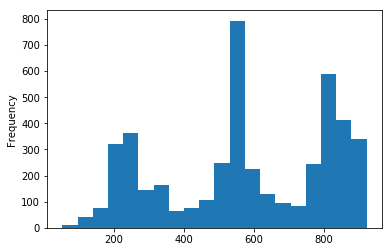

In [4]:
raw['LDR1'].plot.hist(bins=20)

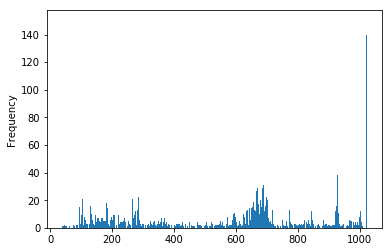

In [5]:
raw['LDR2'].plot.hist(bins=900)

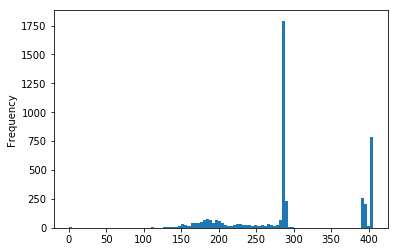

In [6]:
raw['button'].plot.hist(bins=100)

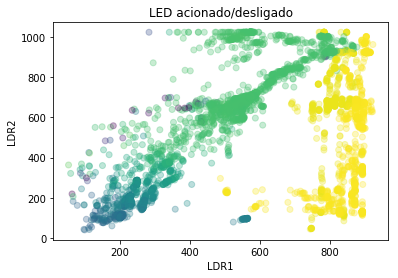

In [7]:
plt.scatter(x=raw['LDR1'], y=raw['LDR2'], c=raw['button'], alpha=0.3)
plt.xlabel("LDR1")
plt.ylabel("LDR2")
plt.title("LED acionado/desligado")
plt.savefig("plot_raw.png", dpi=600)

# Pre processamento dos dados

In [8]:
processed = raw.copy()

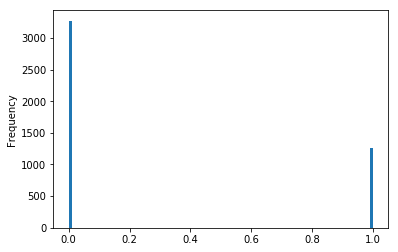

In [9]:
# Transformação de dados do botão: numérico->categótico

#Técnica de programação: selecionando e substituindo
#processed.loc[:,'button'] = np.where(processed.loc[:,'button']>350, 1, 0)

# Técnica de programação: aplicando uma função para cada linha
    processed.loc[:,'button'] = processed.loc[:,'button'].map(lambda x: 1 if x>350 else 0)

processed['button'].plot.hist(bins=100)

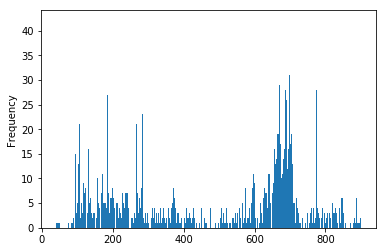

In [10]:
# Remoção de ruídos (falso contato)

# Técnica de programação: seleção simples, porem mais eficiente (usando chaining operation)
# processed = processed.loc[processed['LDR2'].lt(900), :]

# Técnica de programação: seleção simples
processed = processed[processed['LDR2']<900]

processed['LDR2'].plot.hist(bins=900)

In [11]:
# Removação de variáveis inúteis (ID)
# Técnica de programação: operação inplace, isto é, com substituição automática no dataframe original
processed.drop(['id'], axis=1, inplace=True)
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3715 entries, 0 to 4529
Data columns (total 3 columns):
LDR1      3715 non-null int64
LDR2      3715 non-null int64
button    3715 non-null int64
dtypes: int64(3)
memory usage: 116.1 KB


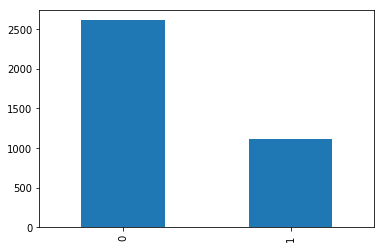

In [12]:
# Balanceamento de dados (pois off>>on)
# Baseado nesse tutorial: https://elitedatascience.com/imbalanced-classes
processed['button'].value_counts().plot.bar()

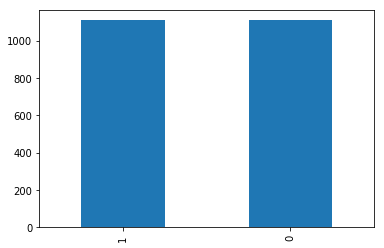

In [13]:
from sklearn.utils import resample

# Separar as classes
df_majority = processed[processed.button==0]
df_minority = processed[processed.button==1]

# Downsample da maior classe
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],
                                 random_state=123) # reproducible results
 
balanced = pd.concat([df_majority_downsampled, df_minority])
balanced['button'].value_counts().plot.bar()

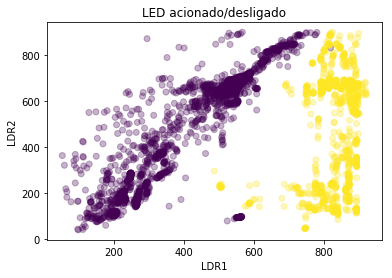

In [14]:
plt.scatter(x=processed['LDR1'], y=processed['LDR2'], c=processed['button'], alpha=0.3)
plt.xlabel("LDR1")
plt.ylabel("LDR2")
plt.title("LED acionado/desligado")

processed.to_csv("dados_preprocessados.csv")
plt.savefig("plot_clean.png", dpi=600)

# Treinando o modelo

In [15]:
# Dividimos nossos dados em dois grupos independentes (cross validation)
from sklearn.model_selection import train_test_split

X = processed.drop('button', axis=1)
y = processed ['button']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200)

MAE:                 0.0008968609865470852
RMSE:                0.029947637411773993
Percentual:          0.3076923076923077 %


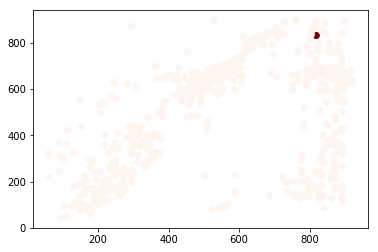

In [16]:
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

model = SVC()
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
print ("MAE:                ", metrics.mean_absolute_error(y_test, y_hat))
print ("RMSE:               ", np.sqrt(metrics.mean_squared_error(y_test, y_hat)))
print ("Percentual:         ", metrics.mean_absolute_error(y_test,y_hat)/y_test.mean()*100, "%")

# Vizualizar quais são os errados
plt.scatter(x=X_test['LDR1'], y=X_test['LDR2'], c=(y_hat!=y_test), cmap='Reds')

Text(0.5, 1.0, 'fronteira de decisão')

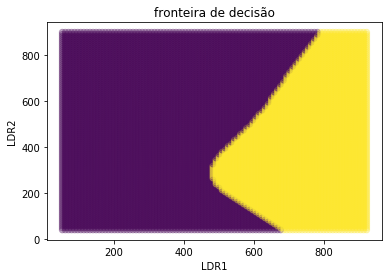

In [20]:
# Cria um espaço 2D igualmente espaçado (linear space = linspace)
# Simula as possibidades de entrada pro modelo (dentro do range no qual ele foi treinado)
n=100
X_val=pd.DataFrame(columns=['LDR1', 'LDR2'])
vec_LDR1 = np.linspace(X['LDR1'].min(),X['LDR1'].max(), n)
vec_LDR2 = np.linspace(X['LDR2'].min(),X['LDR2'].max(), n)
X_val = []
for LDR1 in vec_LDR1:
    for LDR2 in vec_LDR2:
        X_val.append([LDR1,LDR2])
    
X_val = pd.DataFrame(X_val, columns=['LDR1', 'LDR2'])

# Fronteira de decisão do algoritmo
y_hat = model.predict(X_val)
plt.scatter(x=X_val['LDR1'], y=X_val['LDR2'], c=y_hat, alpha=0.3)
plt.xlabel("LDR1")
plt.ylabel("LDR2")
plt.title("fronteira de decisão")

# Clustering

In [18]:
from sklearn.cluster import DBSCAN
model2 = DBSCAN(eps=30) # O parâmetro eps deve ser determinado empiricamente. Veja a documentação da função
model2.fit(X)
unique, counts = np.unique(model2.labels_, return_counts=True)
print("Classes encontradas: " + str(dict(zip(unique, counts))))

Classes encontradas: {-1: 64, 0: 45, 1: 2461, 2: 591, 3: 451, 4: 6, 5: 7, 6: 8, 7: 5, 8: 9, 9: 8, 10: 13, 11: 4, 12: 13, 13: 13, 14: 7, 15: 4, 16: 6}


Classes encontradas: {1: 2461, 2: 591, 3: 451}


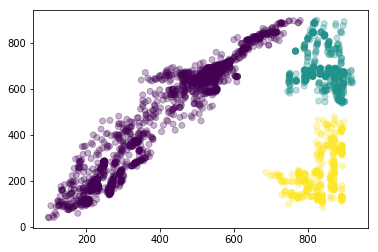

In [19]:
# Filtra apenas os clusters com mais de n_min elementos
n_min = 300
labels_filtered = model2.labels_[[x in unique[counts>n_min] for x in model2.labels_]]
X_filtered = X[[x in unique[counts>n_min] for x in model2.labels_]]

unique, counts = np.unique(labels_filtered, return_counts=True)
print("Classes encontradas: " + str(dict(zip(unique, counts))))

plt.scatter(x=X_filtered['LDR1'], y=X_filtered['LDR2'], c=labels_filtered, alpha=0.3)